**Problem Statement :**
* Spotify aims to enhance its app by analyzing over `52,702` user reviews from the `Google Play Store` to understand user sentiment and key feedback themes.
  
* By examining user reviews, Spotify seeks to uncover `positive and negative trends`, highlight common issues, and pinpoint areas for improvement.

* This information can be a critical resource for `Spotify’s product development team`, providing actionable insights that will ultimately enhance `user satisfaction`.

### Import Required Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [4]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Loading the Data

In [6]:
reviews_df = pd.read_csv('data/DATASET (1).csv')

reviews_df.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


### 2. Exploratory Data Analysis

In [7]:
reviews_df.shape

(52702, 2)

* Dataset consists of `52702` doucmnets, `2` features were `Reviews, Label`.

In [10]:
reviews_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52702 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52702 non-null  object
dtypes: object(2)
memory usage: 823.6+ KB


* There are missing values in `Review` Column we need to handle it by removing.

#### Checking Duplicate values

In [8]:
reviews_df.duplicated().sum() 

1229

In [10]:
reviews_df[reviews_df.duplicated(subset = ['Review'])][:10] 

,Review,label
1848,Way too many ads,NEGATIVE
2391,Good app for songs,POSITIVE
2871,I love Spotify.,POSITIVE
2883,Too many ads,NEGATIVE
3020,Too much ads,NEGATIVE
3129,Amazing music app,POSITIVE
3174,Too many ads,NEGATIVE
3571,Too much ads,NEGATIVE
3917,Too much ads,NEGATIVE
4116,Way too many ads,NEGATIVE


In [12]:
reviews_df.drop_duplicates(inplace= True)

* Clearly shows that there are documents repeated multiple times.

#### Checking Null values

In [14]:
reviews_df['Review'].isnull().sum() 

1

In [16]:
reviews_df.dropna(subset= ['Review'], inplace = True) 

In [18]:
reviews_df.shape 

(51472, 2)

### 2.a. Explore the Data Distribution of Target Variable


In [29]:
reviews_df['label'].value_counts() 

label
NEGATIVE    29345
POSITIVE    22127
Name: count, dtype: int64

In [31]:
reviews_df['label'].value_counts(normalize=True) 

label
NEGATIVE    0.570116
POSITIVE    0.429884
Name: proportion, dtype: float64

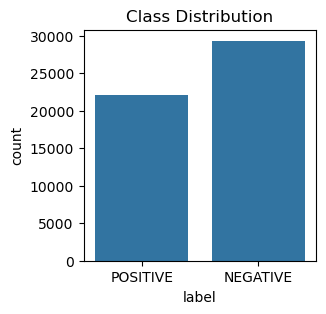

In [33]:
fig, ax = plt.subplots(figsize=(3,3))

ax.set_title('Class Distribution')
sns.countplot(data= reviews_df, x='label')

plt.show()

* Clearly shown in plot there is slight imbalance in the dataset where positive class has 15% less datapoints compared to Negative.
* It is not going to be affect our predictions.

### 2.b. Visualizing the distribution of most frequent words

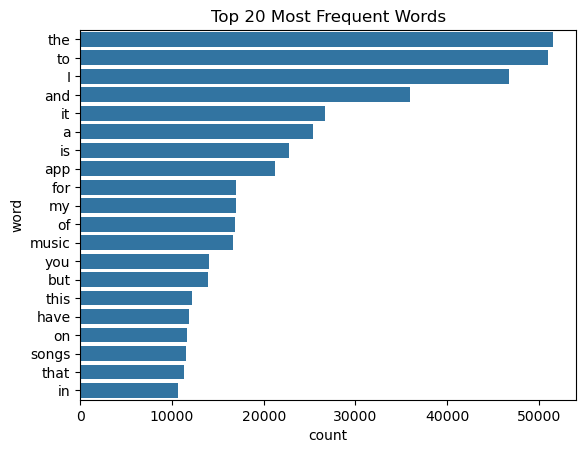

In [37]:
from collections import Counter

# Get all words in the text
all_words = " ".join(reviews_df['Review'].values).split()
word_counts = Counter(all_words)

# Get the most common words
common_words = word_counts.most_common(20)

# Convert to DataFrame for plotting
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot the most common words
sns.barplot(data=common_words_df, x='count', y='word')
plt.title('Top 20 Most Frequent Words')
plt.show()

* `Top 20` Most frequent words in our corpus most likely a `stop words in NLP`, in `sentiment analysis` these words doesn't specify meaning.

### 2.c. Classwise WordCloud - Explore the Relationships between each pair of Inputs and Output

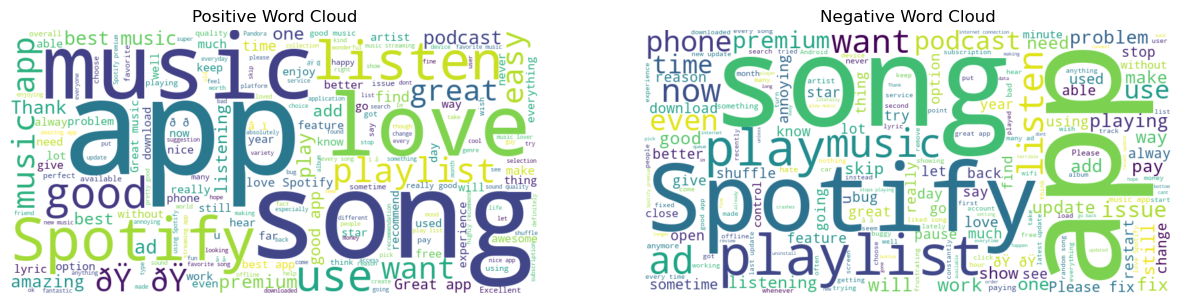

In [41]:
from wordcloud import WordCloud

# Word cloud for Positive messages
positive_text = " ".join(reviews_df[reviews_df['label'] == 'POSITIVE']['Review'].values)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Word cloud for Negative messages
negative_text = " ".join(reviews_df[reviews_df['label'] == 'NEGATIVE']['Review'].values)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display the word clouds
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(positive_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Positive Word Cloud')
ax[1].imshow(negative_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Negative Word Cloud')
plt.show()

**Observations :**
- 1.Words like `Song, app, spotify, music, love, listen, playlist` are most frequent words in both `negative and positive class`.
- 2.In `Negative class` words like `ad, issue, premium, fix` clearly representing problems faced by users while using application
it leads to bad experience for users.
- 3.There is a clear need to preprocess the text data as some of tokens are special characters(i.e. cleaning).

### 3. Data Preprocessing 
#### Note : Before Applying `Text Vectorization` techniques must do `Text preprocessing` on the raw text data


In [44]:
reviews_df['Review'].iloc[0]

'Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.'

In [45]:
reviews_df['Review'].iloc[450]

"It's a very good app for music...loved it a lot.. but today when I'm trying to open the app it's not working even after reinstallation, it's still not opening. Please fix the glitch"

* There are punctuations, whitespaces need to remove from corpus.

In [20]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean(doc): 
    # doc is a string of text
    
    # Let's define a regex to match special characters and digits
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc) 
    doc = re.sub(r'\s+', ' ', doc)
    doc = doc.strip()

    # Convert to lowercase
    doc = doc.lower()
        
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Stop word removal
    stop_words = list(set(stopwords.words('english')))
    custom_stopwords = ['app', 'music','play', 'spotify', 'song', 'listen', 'play','get', 'playlist']
    stop_words = stop_words + custom_stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join and return
    return " ".join(lemmatized_tokens)

In [21]:
def tokenizer(doc):
    # Tokenization
    return nltk.word_tokenize(doc)

### 😍Visualizing the impact of the text cleaning process

In [24]:
from tqdm import tqdm, tqdm_notebook

tqdm.pandas()

In [26]:
# cleaning the raw text data
reviews_df['clean_Review'] = reviews_df['Review'].progress_apply(lambda x: clean(x))

reviews_df[['Review', 'clean_Review']]

100%|██████████| 51472/51472 [00:28<00:00, 1801.57it/s]


,Review,clean_Review
0,"Great music service, the audio is high quality...",great service audio high quality easy use also...
1,Please ignore previous negative rating. This a...,please ignore previous negative rating super g...
2,"This pop-up ""Get the best Spotify experience o...",pop best experience android annoying please le...
3,Really buggy and terrible to use as of recently,really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,dear song put shuffle
...,...,...
52696,Bass volume song quality is appreciative,bass volume quality appreciative
52697,Yes the best,yes best
52698,Spotify won my heart in Feb 2024 You won my he...,heart feb heart lyric language educational pod...
52699,I tried to open the app and it wont open I res...,tried open wont open restarted phone ill tap i...


### 4. Data Preparation

In [27]:
# Preparing the target variable

reviews_df['label'] = reviews_df['label'].apply(lambda x: 0 if x == 'NEGATIVE' else 1)

reviews_df.head()

,Review,label,clean_Review
0,"Great music service, the audio is high quality...",1,great service audio high quality easy use also...
1,Please ignore previous negative rating. This a...,1,please ignore previous negative rating super g...
2,"This pop-up ""Get the best Spotify experience o...",0,pop best experience android annoying please le...
3,Really buggy and terrible to use as of recently,0,really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,0,dear song put shuffle


### Segregate Inputs (X) and Output (y)

In [67]:
X = reviews_df['clean_Review']
y = reviews_df['label']

### Split the data into Train and Test


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(41177,) (41177,)
(10295,) (10295,)


### BOW Text Vectorization: Apply CountVectorizer

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a vectorizer
bow_vect = CountVectorizer(ngram_range=(1, 2))

%time X_train_transformed_bow = bow_vect.fit_transform(X_train['clean_Review'])

print()
print(f"Shape of X_train_transformed (# of docs, # of unique vocabulary): {X_train_transformed_bow.shape}")
print(f"Type of X_train_transformed (i.e. Compressed Sparse Row (CSR) format): {type(X_train_transformed_bow)}")
print(f"Vocabulary learned: {bow_vect.get_feature_names_out()[:10]}")

CPU times: total: 2.25 s
Wall time: 3.69 s

Shape of X_train_transformed (# of docs, # of unique vocabulary): (41177, 244279)
Type of X_train_transformed (i.e. Compressed Sparse Row (CSR) format): <class 'scipy.sparse._csr.csr_matrix'>
Vocabulary learned: ['aa' 'aa misinformation' 'aa playing' 'aa rhe' 'aa sakte' 'aaa'
 'aaa title' 'aaaa' 'aaaaaaaa' 'aaaaasssseeeeee']


In [64]:
X_test_transformed_bow = bow_vect.transform(X_test['clean_Review'])

print(f'Shape of X_test_transformed: {X_test_transformed_bow.shape}')

Shape of X_test_transformed: (10295, 244279)


### TF IDF Text Vectorization: Apply TF-IDF Vectorizer (Note: We won't use `TF-IDF` Text Vectorization)

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))

%time X_train_transformed_tfidf = tfidf_vect.fit_transform(X_train['clean_Review'])

print()
print(f"Shape of output (# of docs, # of unique vocabulary): {X_train_transformed_tfidf.shape}")
print(f"Type of output (i.e. Compressed Sparse Row (CSR) format): {type(X_train_transformed_tfidf)}")

CPU times: total: 2.23 s
Wall time: 3.82 s

Shape of output (# of docs, # of unique vocabulary): (41177, 244279)
Type of output (i.e. Compressed Sparse Row (CSR) format): <class 'scipy.sparse._csr.csr_matrix'>


In [67]:
X_test_transformed_tfidf = tfidf_vect.transform(X_test['clean_Review'])

print(f'Shape of X_test_transformed: {X_test_transformed_tfidf.shape}')

Shape of X_test_transformed: (10295, 244279)


### 5. Model Building and Evaluation


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

In [70]:
classifiers = [
    LogisticRegression(),
    MultinomialNB(),
    RandomForestClassifier(n_estimators=20)
] 

In [71]:
import time

vectorizers = ['X_train_transformed_bow', 'X_train_transformed_tfidf']

accuracy_results = {
    'X_train_transformed_bow': [],
    'X_train_transformed_tfidf': []
}

classifier_names = []

for vect in vectorizers:
    for classifier in classifiers:
        if vect == 'X_train_transformed_bow':
            model = classifier.fit(X_train_transformed_bow, y_train)

            # Start timing the prediction
            start_time = time.time()
            pred = model.predict(X_test_transformed_bow)
            end_time = time.time()
        else:
            model = classifier.fit(X_train_transformed_tfidf, y_train)
            
            # Start timing the prediction
            start_time = time.time()
            pred = model.predict(X_test_transformed_tfidf)
            end_time = time.time()
        
        accuracy = accuracy_score(pred, y_test)
        prediction_time = end_time - start_time

        print(f'Accuracy of {classifier.__class__.__name__} on {vect} is {accuracy}')
        print(f'Prediction time: {prediction_time:.4f} seconds')
        
        accuracy_results[vect].append(accuracy)
        if vect == 'X_train_transformed_bow': 
            classifier_names.append(classifier.__class__.__name__)

    print()

Accuracy of LogisticRegression on X_train_transformed_bow is 0.8792617775619233
Prediction time: 0.0000 seconds
Accuracy of MultinomialNB on X_train_transformed_bow is 0.8612918892666342
Prediction time: 0.0160 seconds
Accuracy of RandomForestClassifier on X_train_transformed_bow is 0.8518698397280233
Prediction time: 0.5474 seconds

Accuracy of LogisticRegression on X_train_transformed_tfidf is 0.8755706653715396
Prediction time: 0.0000 seconds
Accuracy of MultinomialNB on X_train_transformed_tfidf is 0.8473045167557066
Prediction time: 0.0104 seconds
Accuracy of RandomForestClassifier on X_train_transformed_tfidf is 0.8565322972316659
Prediction time: 0.5383 seconds



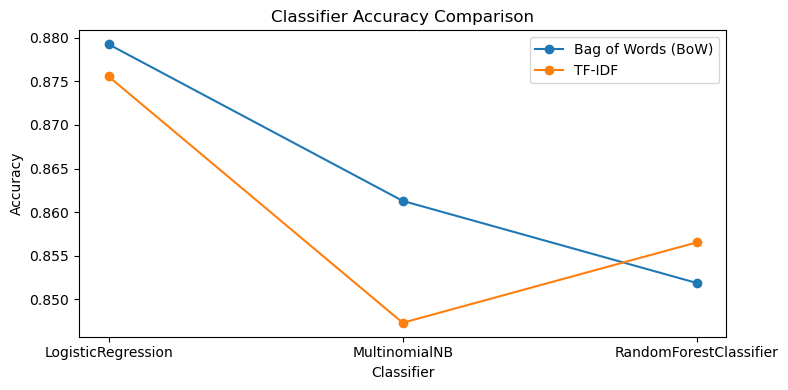

In [72]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 4))

for vect, accuracies in accuracy_results.items():
    ax.plot(classifier_names, accuracies, marker='o', label=vect)

ax.set_title('Classifier Accuracy Comparison')
ax.set_xlabel('Classifier')
ax.set_ylabel('Accuracy')
ax.legend(['Bag of Words (BoW)', 'TF-IDF'])
plt.tight_layout()
plt.show()

### Logistic Regression

In [83]:
# Building the Logistic Regression model
log_regressor = LogisticRegression()

log_regressor.fit(X_train_transformed_bow, y_train)
pred = log_regressor.predict(X_test_transformed_bow) 

# Model Evaluation
accuracy = accuracy_score(pred, y_test)
print('Accuracy of '+log_regressor.__class__.__name__+' is '+str(accuracy))

Accuracy of LogisticRegression is 0.8792617775619233


In [84]:
from sklearn.metrics import classification_report

print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      5780
           1       0.87      0.85      0.86      4515

    accuracy                           0.88     10295
   macro avg       0.88      0.88      0.88     10295
weighted avg       0.88      0.88      0.88     10295



**Observation**

* Both `Bag of words` and `TF-IDF` performed well on our dataset  there is slight difference between them.
* `Logistic Regression` with `Bag of words` got `high accuracy` compared to other classification models.

## 🧐Experimentation: Using Pretrained `Word2Vec` model for Text Vectorization

In [89]:
# import gensim library

import gensim

print(gensim.__version__)

4.3.3


In [90]:
import gensim.downloader as api

print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [91]:
# Loading the word2vec model
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(r"D:\Pretrained_models\GoogleNews-vectors-negative300.bin", binary=True)

print(type(model))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [92]:
reviews_df['Tokenised_Review'] = reviews_df['clean_Review'].apply(lambda doc : doc.split())

reviews_df.head()

,Review,label,clean_Review,Tokenised_Review
0,"Great music service, the audio is high quality...",1,great service audio high quality easy use also...,"[great, service, audio, high, quality, easy, u..."
1,Please ignore previous negative rating. This a...,1,please ignore previous negative rating super g...,"[please, ignore, previous, negative, rating, s..."
2,"This pop-up ""Get the best Spotify experience o...",0,pop best experience android annoying please le...,"[pop, best, experience, android, annoying, ple..."
3,Really buggy and terrible to use as of recently,0,really buggy terrible use recently,"[really, buggy, terrible, use, recently]"
4,Dear Spotify why do I get songs that I didn't ...,0,dear song put shuffle,"[dear, song, put, shuffle]"


In [94]:
# Take documents and convert it to average word embedding
def get_document_vector(doc, model):
    tokens = [word for word in doc if word in model]
    if tokens:      
        doc_embedding = np.mean(model[tokens], axis=0)
    else:
        doc_embedding = np.zeros(model.vector_size)
    return doc_embedding

In [95]:
reviews_df['w2v_doc_embeddings'] = reviews_df["Tokenised_Review"].progress_apply(lambda doc : get_document_vector(doc, model))

100%|██████████| 51472/51472 [00:11<00:00, 4498.92it/s]


In [97]:
X = reviews_df['w2v_doc_embeddings'].to_list()
y = reviews_df['label'].to_list() 

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [99]:
# Building the Logistic Regression model
classifier = LogisticRegression()

classifier.fit(X_train, y_train)
pred = classifier.predict(X_test) 

# Model Evaluation
accuracy = accuracy_score(pred, y_test)
print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))

Accuracy of LogisticRegression is 0.8728508984944148


In [100]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6154
           1       0.82      0.88      0.85      4141

    accuracy                           0.87     10295
   macro avg       0.87      0.87      0.87     10295
weighted avg       0.88      0.87      0.87     10295



**Observation**
* After performing vectorization using `word2vec` model, `Logistic Regression` model given `87 accuracy`.

## 🧐Experimentation: Building LSTM Sequential Model

In [257]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, InputLayer, Embedding, LSTM, GRU, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [292]:
fv = reviews_df['clean_Review']

cv = reviews_df['label']

In [294]:
tk = Tokenizer(num_words= 10000, oov_token= "oov")

In [296]:
tk.fit_on_texts(fv)

In [298]:
len(tk.word_index)

18978

In [300]:
len(tk.word_counts)

18977

In [302]:
seq = tk.texts_to_sequences(fv)

seq

[[8, 60, 171, 439, 79, 56, 14, 28, 912, 446, 228],
 [20, 2022, 477, 1117, 358, 249, 8, 62, 479, 46],
 [299, 15, 67, 139, 45, 20, 87, 501],
 [17, 191, 243, 14, 150],
 [1607, 2, 152, 63],
 [145, 102, 71, 484, 117, 172, 1896, 10, 18, 33],
 [5, 160, 90, 1395, 26],
 [36,
  434,
  368,
  593,
  578,
  1897,
  728,
  397,
  3412,
  316,
  1015,
  72,
  33,
  316,
  148,
  762,
  11,
  379,
  728,
  397,
  1564,
  786,
  1207,
  847,
  329,
  1455,
  20,
  23,
  4,
  78,
  508,
  134,
  40],
 [8, 15, 1186, 70, 53, 16, 34, 2, 51, 2, 560, 359, 132, 15],
 [511,
  1414,
  117,
  2214,
  930,
  1996,
  841,
  119,
  60,
  4,
  1777,
  12,
  52,
  842,
  3,
  5472,
  1456,
  729,
  241,
  39,
  662,
  3,
  489,
  3413,
  48,
  1438,
  212,
  8944,
  432,
  3058],
 [222],
 [472,
  7,
  286,
  959,
  6,
  298,
  88,
  351,
  123,
  4298,
  6629,
  1439,
  679,
  34,
  7,
  286,
  1025,
  1227,
  480,
  4,
  19,
  10,
  11,
  108,
  1025,
  128,
  11,
  679,
  1227,
  49],
 [184, 54, 84, 93, 78, 1746, 

In [304]:
# padding the sequences with zeros
pad_seq = pad_sequences(seq, padding='post')

pad_seq

array([[   8,   60,  171, ...,    0,    0,    0],
       [  20, 2022,  477, ...,    0,    0,    0],
       [ 299,   15,   67, ...,    0,    0,    0],
       ...,
       [ 797, 2381,  797, ...,    0,    0,    0],
       [ 120,   85,  438, ...,    0,    0,    0],
       [  81,  976,  386, ...,    0,    0,    0]])

In [308]:
pad_seq.shape

(51472, 129)

#### Note : splitting the data into train,validation, test

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(pad_seq, cv, test_size=0.2, random_state=42)

X_temp, X_test, y_temp, y_test = train_test_split(pad_seq, cv, test_size=0.2, random_state=42)

In [331]:
# Building the Stacked LSTM model

model = Sequential() 
model.add(InputLayer(shape = (129,))) 
model.add(Embedding(input_dim=10000, output_dim= 10, mask_zero= True)) # input_dim = len_unique_words, output_dim = dense_vector_size
model.add(LSTM(100, activation= 'tanh', return_sequences= True))
model.add(BatchNormalization()) 
model.add(LSTM(48, activation= 'tanh', return_sequences= True))
model.add(BatchNormalization()) 
model.add(LSTM(10, activation= 'tanh', return_sequences=False))
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer = 'rmsprop', loss = "binary_crossentropy", metrics = ['accuracy'])

In [333]:
# Using callbacks 
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

In [336]:
history = model.fit(
    X_train,  
    y_train, 
    batch_size=32,
    epochs=20,
    validation_data = (X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 274s 213ms/step - accuracy: 0.8555 - loss: 0.3368 - val_accuracy: 0.8573 - val_loss: 0.3371 - learning_rate: 0.0010
Epoch 2/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 199s 155ms/step - accuracy: 0.8769 - loss: 0.2921 - val_accuracy: 0.8757 - val_loss: 0.2947 - learning_rate: 0.0010
Epoch 3/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 191s 148ms/step - accuracy: 0.8877 - loss: 0.2756 - val_accuracy: 0.8734 - val_loss: 0.3080 - learning_rate: 0.0010
Epoch 4/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 246s 191ms/step - accuracy: 0.8943 - loss: 0.2625 - val_accuracy: 0.8737 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 5/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 198s 154ms/step - accuracy: 0.9001 - loss: 0.2454 - val_accuracy: 0.8754 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 6/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 209s 162ms/step - accuracy: 0.9072 - loss: 0.2351 - val_accuracy: 0.8812 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 7/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 217s 169ms

In [356]:
from keras.models import load_model

# Load the best model
best_model = load_model('best_model.keras')

predictions = best_model.predict(X_test)

predicted_classes = (predictions > 0.5).astype(int)

accuracy = accuracy_score(predicted_classes, y_test)

print(f"Models's Accuracy: {accuracy}")

322/322 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8856 - loss: 0.2778
Loss: 0.28035107254981995, Accuracy: 0.8812044858932495


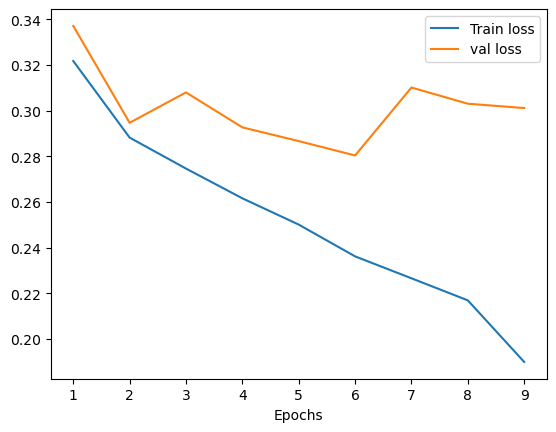

In [346]:
# plotting the loss across epochs
plt.plot(range(1, 10), history.history['loss'], label= 'Train loss')
plt.plot(range(1, 10), history.history['val_loss'], label= 'val loss')
plt.xlabel('Epochs')
plt.legend()

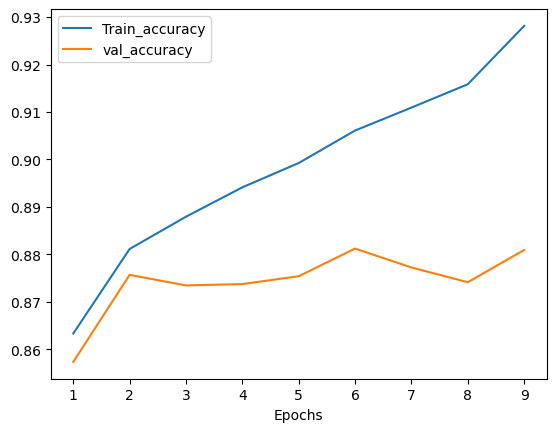

In [352]:
# plotting the accuracy across epochs
plt.plot(range(1, 10), history.history['accuracy'], label= 'Train_accuracy')
plt.plot(range(1, 10), history.history['val_accuracy'], label= 'val_accuracy')
plt.xlabel('Epochs')
plt.legend()

**Observations on LSTM Model :**

- **Training Accuracy:** LSTM model achieved an accuracy of **93%** on the training set.
- **Validation Accuracy:** The model's accuracy on the validation set was **88%**.
- **Overfitting:** There is a slight overfitting observed in the model, indicated by the higher training accuracy compared to the validation accuracy. 

### Saving the LSTM Model and Tokenizer

In [378]:
from pickle import dump

dump(tk, open('pickle/tokenizer.pkl', 'wb'))

best_model.save('model/LSTM_Model.keras')  

**Conclusion :**

1. **Address Technical Issues:** Focus on resolving recurring bugs and optimizing app performance to enhance user experience.

2. **Enhance User Features:**  Develop features that users have requested, such as `better playlist management` and music discovery options, while also  `improving the ad experience`.

3. **Leverage User Feedback:** Establish continuous feedback mechanisms to guide product development and ensure updates align with user needs.

4. **Communicate Effectively:** Keep users informed about updates and fixes based on their feedback to build trust and loyalty.

## **Implementing various Algorithms to find the Best Model**

In [43]:
import joblib
from joblib import Memory

import os

In [89]:
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

In [73]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='accuracy', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(X_train, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 12.2 s
Wall time: 21.4 s
Score on Test Data:  0.8508013598834385
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 2min 47s
Wall time: 5min 51s
Score on Test Data:  0.8000971345313259
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [77]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', MultinomialNB(alpha=10))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1500)),
                ('classifier', DecisionTreeClassifier())])



In [91]:
for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    %time y_test_pred = model.predict(X_test)
    print("Test Score", accuracy_score(y_test, y_test_pred))
    
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

********** naive_bayes **********
CPU times: total: 93.8 ms
Wall time: 156 ms
Test Score 0.8508013598834385
Model Size: 433943 Bytes
********** decision_tree **********
CPU times: total: 62.5 ms
Wall time: 216 ms
Test Score 0.8000971345313259
Model Size: 999917 Bytes
